In [13]:
import numpy as np
import matplotlib.pyplot as plt
from cpymad.madx import Madx
import pandas as pd
from pybt.tools.plotters import *
from pybt.tools.air_scattering_functions import *

In [14]:
T = 23.08 # GeV kinetic energy
# T = 4.54 # GeV kinetic energy ion equivalent of 750 MeV/u
E0 = 0.938 # GeV/c^2 proton rest mass
E = T + E0 # total energy
gamma = E / E0 # gamma
beta = np.sqrt(1-gamma**(-2))
p = E*beta # GeV/c beam momentum

print(f"gamma = {round(gamma,3)}")
print(f"beta = {round(beta,3)}")
print(f"p = {round(p,3)} GeV/c")

gamma = 25.606
beta = 0.999
p = 24.0 GeV/c


In [15]:
# Matched initial parameters
betx0 = 154.0835045206266
bety0 = 5.222566527078791
alfx0 = -36.90472944993891
alfy0 = 0.2523074897915478
Dx0 = 0.13
Dy0 = 0.0
Dpx0 = 0.02
Dpy0 = 0.0
exn = 7.639770207283603e-06
eyn =  3.534081877201574e-06
sige = 0.000679081344780741

ex = exn/(beta*gamma)
ex_initial = ex
ey = eyn/(beta*gamma)
ey_initial = ey

with open('tempfile', 'w') as f:
    madx = Madx(stdout=f,stderr=f)
    madx.option(verbose=True, debug=False, echo=True, warn=True, twiss_print=False)

madx.input('''

QF : QUADRUPOLE, L = 2, APERTYPE=CIRCLE, APERTURE={0.025};
QD : QUADRUPOLE, L = 2, APERTYPE=CIRCLE, APERTURE={0.025};

QF1 : QF, K1 := kQF1;
QD2 : QD, K1 := kQD2;
QF3 : QF, K1 := kQF3;
QD4 : QD, K1 := kQD4;

kQF1 = 0.32730047;
kQD2 = -0.36102915;
kQF3 = 0.32789126;
kQD4 = -0.1991137;

simple_seq: SEQUENCE, refer = exit, l = 100;
QF1 : QF1, AT=2;
QD2 : QD2, AT=5;
QF3 : QF3, AT=8;
QD4 : QD4, AT=11;
END : MARKER, AT=100;
ENDSEQUENCE;
''')

# Add the air regions
sequence = "simple_seq"
add_air_region(madx, "1", sequence, 20, 30, 1)
add_air_region(madx, "2", sequence, 50, 60, 2)
add_air_region(madx, "3", sequence, 80, 90, 3)
# add_hidden_marker(madx, sequence, 20, 100, 1)

madx.command.beam(particle='PROTON',pc=p,ex=ex,ey=ey)
madx.input('BRHO      := BEAM->PC * 3.3356;')
madx.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APERTYPE,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')
madx.use(sequence=sequence)
twiss = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=Dx0, Dy=Dy0, Dpx=Dpx0, Dpy=Dpy0).dframe()


In [16]:
# Air scattering
madx.use(sequence=sequence)
madx.input(f"SAVEBETA, LABEL=savebeta_air, PlACE = AIR_START, SEQUENCE={sequence};")
twiss = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=Dx0, Dy=Dy0, Dpx=Dpx0, Dpy=Dpy0).dframe()
twiss, twiss_scattered = process_scattering(madx, exn, eyn, beta, gamma, sequence, "end", p, twiss, ex_initial, ey_initial)

20.0


50.0
80.0


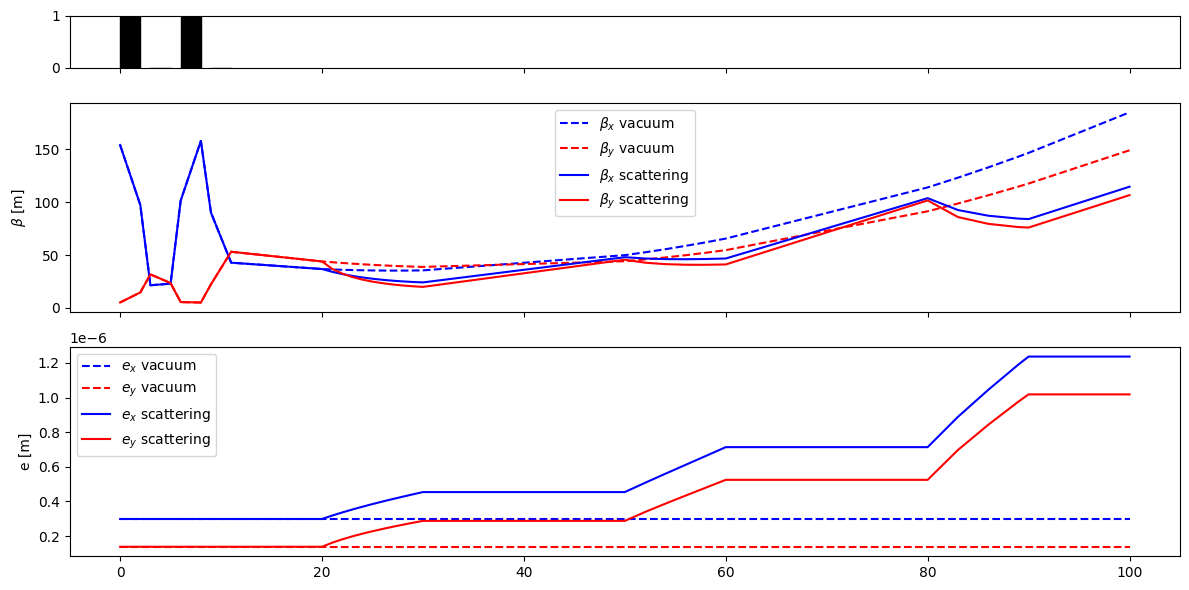

In [17]:
fig, ax = plt.subplots(3,1, figsize=(12, 6), sharex=True, height_ratios=[1, 4, 4, ], tight_layout=True)
draw_synoptic(ax[0], twiss)
ax[1].plot(twiss.s, twiss.betx, ls="--", c="b", label=r'$\beta_{x}$ vacuum')
ax[1].plot(twiss.s, twiss.bety, ls="--", c="r", label=r'$\beta_{y}$ vacuum')
ax[1].plot(twiss_scattered.s, twiss_scattered.betx, c="b", label=r'$\beta_{x}$ scattering')
ax[1].plot(twiss_scattered.s, twiss_scattered.bety, c="r", label=r'$\beta_{y}$ scattering')
ax[1].set_ylabel(r'$\beta$ [m]')
ax[1].legend()

ax[2].plot(twiss.s, twiss.ex, ls="--", c="b",  label='$e_{x}$ vacuum')
ax[2].plot(twiss.s, twiss.ey, ls="--", c="r",  label='$e_{y}$ vacuum')
ax[2].plot(twiss_scattered.s, twiss_scattered.ex, c="b",  label='$e_{x}$ scattering')
ax[2].plot(twiss_scattered.s, twiss_scattered.ey, c="r",  label='$e_{y}$ scattering')
ax[2].set_ylabel('e [m]')
ax[2].legend()

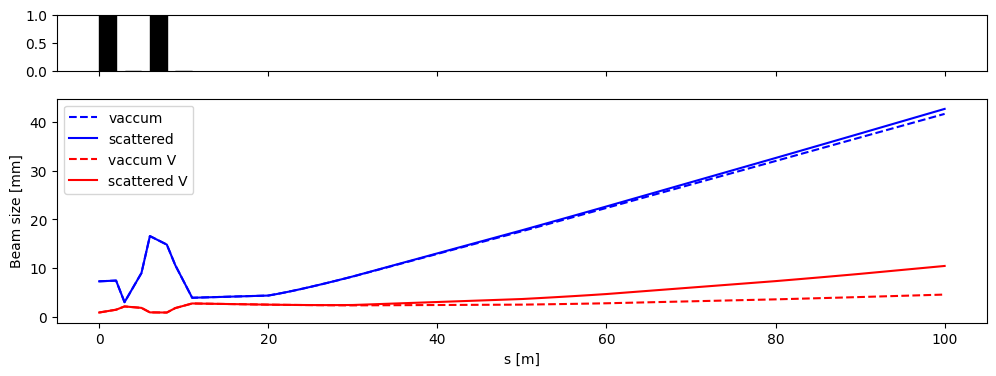

In [18]:
fig, ax = plt.subplots(2,1 ,figsize=(12, 4), sharex=True, height_ratios=[1, 4])

draw_synoptic(ax[0], twiss_scattered)

ax[1].plot(twiss.s, 1000*beam_size(twiss.betx, twiss.dx, twiss.ex, sige, 1), ls="--", c="b", label='vaccum')
ax[1].plot(twiss_scattered.s, 1000*beam_size(twiss_scattered.betx, twiss_scattered.dx, twiss_scattered.ex, sige, 1), c="b", label='scattered')

ax[1].plot(twiss.s, 1000*beam_size(twiss.bety, twiss.dy, twiss.ey, sige, 1), ls="--", c="r", label='vaccum V')
ax[1].plot(twiss_scattered.s, 1000*beam_size(twiss_scattered.bety, twiss_scattered.dy, twiss_scattered.ey, sige, 1), c="r", label='scattered V')

ax[1].set_xlabel('s [m]')
ax[1].set_ylabel('Beam size [mm]')
ax[1].legend()

In [19]:
print(f"alfx analytical before = {round(twiss.loc['end'].alfx,2)} after = {round(twiss_scattered.loc['end'].alfx,2)}")
print(f"betx analytical before = {round(twiss.loc['end'].betx,2)} after = {round(twiss_scattered.loc['end'].betx,2)}")
print(f"ex analytical before = {round(twiss.loc['end'].ex,9)} after = {round(twiss_scattered.loc['end'].ex,9)}")


alfx analytical before = -2.06 after = -1.7
betx analytical before = 185.0 after = 114.68
ex analytical before = 2.99e-07 after = 1.237e-06


In [20]:
beam_size_end_no_scattered = 1000*beam_size(twiss.loc["end"].betx, twiss.loc["end"].dx, twiss.loc["end"].ex, sige, 1)
beam_size_end_scattered = 1000*beam_size(twiss_scattered.loc["end"].betx, twiss_scattered.loc["end"].dx, twiss_scattered.loc["end"].ex, sige, 1)

print(f"Beam size at the end is {round(beam_size_end_no_scattered,1)} mm")
print(f"Beam size scattered at the end is {round(beam_size_end_scattered,1)} mm")
print(f"Beam size increase is {round(100*beam_size_end_scattered/beam_size_end_no_scattered,1) - 100 } %")

Beam size at the end is 41.7 mm
Beam size scattered at the end is 42.7 mm
Beam size increase is 2.5 %
